# Statistics

## Parametric statistics

### Example: fitting a normal distribution to heights

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma, norm

In [3]:
heights = {'Fred': 151, 'Barney': 168, 'Bambam': 162, 'Betty': 151,
           'Dino': 121}

In [4]:
heights.values()

dict_values([151, 168, 162, 151, 121])

In [5]:
# h = np.array(list(heights.values()))
h = np.fromiter(heights.values(), dtype=float)
h

array([151., 168., 162., 151., 121.])

In [6]:
gamma.fit(h)

(227.95784034691542, -103.25325173196285, 1.1128286000161531)

In [7]:
# Capture the fitted parameters (mean and standard deviation)
params = gamma.fit(h)

In [8]:
params

(227.95784034691542, -103.25325173196285, 1.1128286000161531)

In [9]:
# model = gamma(params[0], params[1], params[2])
model = gamma(*params)

In [10]:
h2 = model.rvs(10000)
h2[:10]

array([137.9039698 , 158.79228536, 135.31092308, 149.92535981,
       162.31461619, 145.55164812, 142.14625904, 132.67161673,
       162.01158593, 167.10666417])

In [11]:
x = np.linspace(80, 230, 100)
y = model.pdf(x)

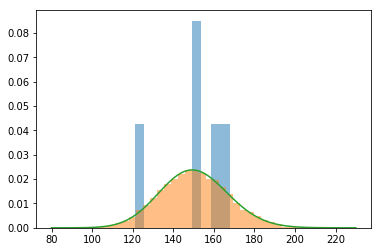

In [12]:
plt.hist(h, density=True, alpha=0.5);
plt.hist(h2, density=True, alpha=0.5, bins=40);
plt.plot(x, y);

In [13]:
from scipy.stats import normaltest

In [14]:
normaltest(h2)

NormaltestResult(statistic=29.62380640824636, pvalue=3.692089089753095e-07)

In [15]:
(_, p_value) = normaltest(h2)

In [16]:
p_value > 0.05

False

So we accept the normality hypothesis.

## Nonparametric statistics

Most of the methods of classical statistics were derived by mathematicians prior
to the advent of modern-day computers. As a result, they mostly describe
solutions in terms of assumptions and probability distributions that are
mathematically convenient but not necessarily reflective of your real-world
data. As a result, statistics has traditionally been hard for non-mathematicians
to learn and easy to mis-apply.

Good news: in the last few decades, recent advances in computing power have
given birth to **nonparametric** statistical methods that are relatively simple
to apply and make fewer assumptions about your data. These can lead to
reasonable conclusions in a wide variety of situations.

### Empirical data fitting

This illustrates a powerful method of fitting a model (pdf) to data empirically.
This is useful when you have no prior information about the governing process or
the parametric form of its distribution.

Here we simulate multiple sources of data from different distributions:

In [17]:
# One way of generating random variates from a normal distribution: using numpy.random (imported as nr)
heights_holland = np.random.randn(1000) * 5 + 180

In [18]:
# Another way: using scipy.stats. This module defines many more distributions that NumPy:
heights_australia = norm(160, 15).rvs(1000)

In [19]:
# Combine all the data into one array
all_heights = np.hstack([heights_australia, heights_holland])

In [20]:
# Manually set the bin boundaries:
b = np.linspace(all_heights.min(), all_heights.max(), 20)

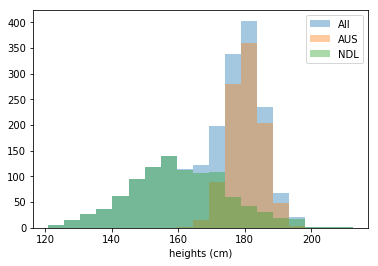

In [21]:
plt.hist(all_heights, bins=b, alpha=0.4)
plt.hist(heights_holland, bins=b, alpha=0.4)
plt.hist(heights_australia, bins=b, alpha=0.4)
plt.legend(['All', 'AUS', 'NDL'])
plt.xlabel('heights (cm)');

In [22]:
from scipy.stats import gaussian_kde

In [23]:
model = gaussian_kde(all_heights)

Now model is "function-like": it can be called like a function as model(x),
passing in the x values to evaluate the pdf over.

In [24]:
x = np.linspace(all_heights.min(), all_heights.max(), 100)
y = model(x)

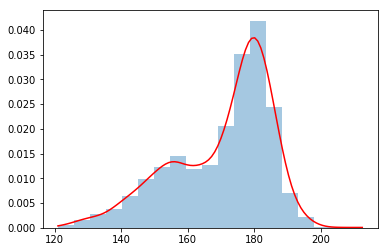

In [25]:
plt.hist(all_heights, bins=b, density=True, alpha=0.4)
plt.plot(x, y, 'r-');

## Bootstrap

The "bootstrap" is a computational procedure that can be used to estimate the
distribution of almost any statistic by repeated random sampling from your data.
It is the best-known from a family of **resampling** procedures. It is used for:
- constructing hypothesis tests
- constructing confidence intervals
- regression

Because it is **nonparametric**, it is particularly useful when working with
data that doesn't come from any known distribution (which includes most real-
world data), or with small sample sizes. It provides a simple and robust
alternative to classical statistics theory (e.g. t-statistic, z-statistic, chi-
square tests, etc.)

### Example: estimating the mean (and confidence intervals for it)

Suppose you have $\approx$ 3652 daily rainfall data for 10 years for some
location and want to draw conclusions about the true mean rainfall (e.g.
overall, or each year, or each month) and confidence intervals about this.

Using classical statistics, one would construct a *t statistic* to do this and
apply a t test while trying not to violate its assumptions too egregiously.
Using the bootstrap, one would instead have a computer do this:

1. Randomly choose the same number of samples (here 3652) **with replacement**
from the original data. There will be repeats in general. Then we compute the
first bootstrap mean $\mu_1$ of this resample.
2. Repeat step 1 many times (e.g. 1000) and compute these further bootstrap
means $\mu_2, ..., \mu_{1000}$.

Then we can construct a bootstrap confidence interval for the purpose of
hypothesis testing.

We could do this manually in Excel, or we can use a pre-written package in
Python or R to do this for us. Here is how we can do this in Python.

### First: read in the data

You can download the rainfall data from the BOM website:
http://www.bom.gov.au/climate/data/

In [47]:
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Import other useful libraries
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Limit the number of rows of DataFrames to display:
pd.options.display.max_rows = 25

# If Altair is installed:
# from altair import Chart, load_dataset

# If Cufflinks is installed:
# import cufflinks as cf
# cf.set_config_file(offline=True)

In [27]:
mitcham = pd.read_csv('Data/Rainfall/Bureau_Rainfall_Mitcham/IDCJAC0009_086074_1800_Data.csv')

Here are the first 5 rows:

In [28]:
mitcham[:5]

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
0,IDCJAC0009,86074,1936,1,1,NaN,NaN,NaN
1,IDCJAC0009,86074,1936,1,2,NaN,NaN,NaN
2,IDCJAC0009,86074,1936,1,3,NaN,NaN,NaN
3,IDCJAC0009,86074,1936,1,4,NaN,NaN,NaN
4,IDCJAC0009,86074,1936,1,5,NaN,NaN,NaN


Let's start by dropping any rows with missing data (NaN values) in the "Rainfall
amount ..." column:

In [29]:
mitcham.dropna(subset=['Rainfall amount (millimetres)'],
               inplace=True)

In [30]:
mitcham[:5]

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
244,IDCJAC0009,86074,1936,9,1,0.0,NaN,Y
245,IDCJAC0009,86074,1936,9,2,0.0,NaN,Y
246,IDCJAC0009,86074,1936,9,3,3.0,1.0,Y
247,IDCJAC0009,86074,1936,9,4,0.0,NaN,Y
248,IDCJAC0009,86074,1936,9,5,0.0,NaN,Y


Here is a random sample of 10 rows:

In [31]:
mitcham.sample(10)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
23488,IDCJAC0009,86074,2000,4,22,6.6,1.0,Y
24862,IDCJAC0009,86074,2004,1,26,0.0,NaN,Y
25628,IDCJAC0009,86074,2006,3,2,0.0,NaN,Y
16134,IDCJAC0009,86074,1980,3,4,0.0,NaN,Y
4879,IDCJAC0009,86074,1949,5,11,0.5,1.0,Y
5592,IDCJAC0009,86074,1951,4,24,0.0,NaN,Y
6856,IDCJAC0009,86074,1954,10,9,1.5,1.0,Y
26112,IDCJAC0009,86074,2007,6,29,0.4,1.0,Y
24375,IDCJAC0009,86074,2002,9,26,0.0,NaN,Y
15475,IDCJAC0009,86074,1978,5,15,0.0,NaN,Y


Let's pull out the rainfall column only:

In [32]:
rain = mitcham['Rainfall amount (millimetres)']

### Histogram of rainfall

We can get some insight into the distribution of daily rainfall values by
plotting a histogram of them like this:

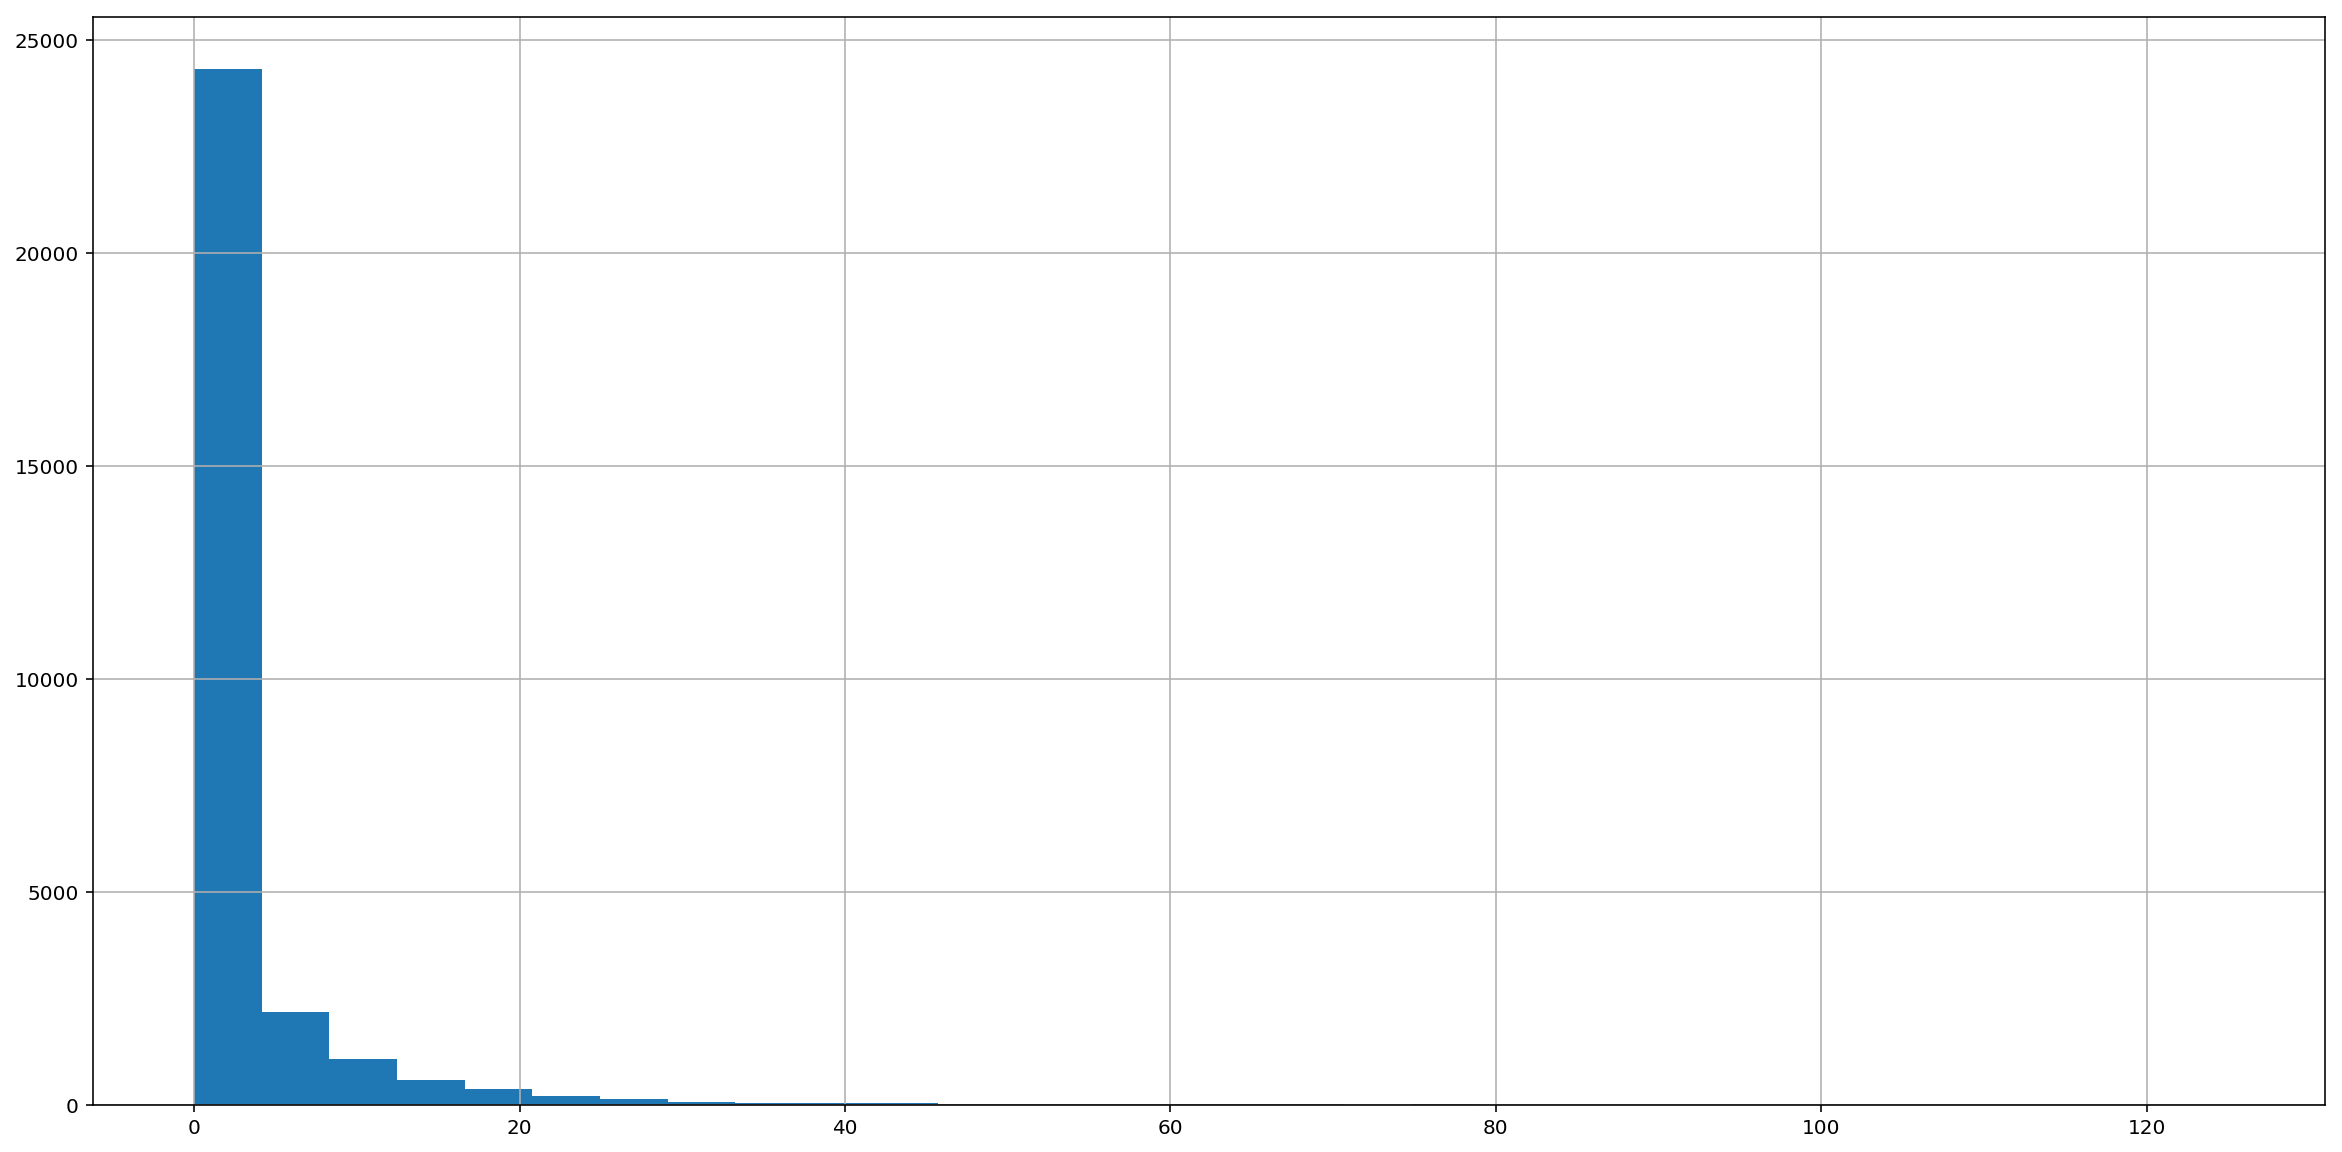

In [33]:
rain.hist(bins=30)

We can see that the daily rainfall is definitely not normally distributed.

### Question: What was the average rainfall across all recorded data?

In [34]:
rain.mean()

2.3594297717019286

### Example: 95% confidence intervals for the mean

We can use the following Python package to construct these confidence intervals
for us automatically:
!pip install scikits.bootstrap

In [35]:
from scikits.bootstrap import ci  # ci = confidence intervals

In [36]:
rain[:10]

244     0.0
245     0.0
246     3.0
247     0.0
248     0.0
249     0.0
250     0.0
251    11.4
252     3.3
253     2.3
Name: Rainfall amount (millimetres), dtype: float64

In [37]:
ci(rain, alpha=0.05, n_samples=1000)

array([2.2968665 , 2.42947213])

So our 95% confidence interval for the average amount of rainfall per day is between 2.29 mm and 2.43 mm.

## Interpreting confidence intervals

So what does the above statement mean?

If we collected daily rainfall data for a million days, with no climate
change, and found the daily average, and then did this 99 more times,
we would expect the average daily rainfall to be between 2.29 mm and 2.43
mm about 95 of those times.

This is the frequentist definition of confidence intervals: the long-term
average falls within this interval with high confidence.

Does this mean that the next 10 days can't all have more than 5 mm of rain? **Of
course not.**

Be careful: such an interpretation of confidence intervals is tempting, and
common, and **wrong**.

(There is another perspective on how to express uncertainty, called the
**Bayesian** perspective. This provides "credible intervals", which are
associated with a "prior" degree of belief about the weather as well as the
data. These are easier to interpret but more mathematically demanding to
construct. We won't go into Bayesian statistics in this course.)

## Analysing extreme events

The mean is rather boring. The bootstrap allows us to find the distribution of
**almost any statistic** on our data, including those that would be difficult
or impossible to compute with classical statistical methods, like the median
or maximum or probabilities of rare events.

### Example: distribution of the wettest day each year

First, we can find the wettest day on record in the sample like this:

In [38]:
rain.max()

124.7

So there was one day when Mitcham recorded over 124 mm of rain. When was this?
We look up the row index first:

In [39]:
rain.idxmax()

9890

and now extract the row from the original data with that index:

In [40]:
mitcham.loc[rain.idxmax()]

Product code                                      IDCJAC0009
Bureau of Meteorology station number                   86074
Year                                                    1963
Month                                                      1
Day                                                       29
Rainfall amount (millimetres)                          124.7
Period over which rainfall was measured (days)             1
Quality                                                    Y
Name: 9890, dtype: object

We can also find the amount of rain on the wettest day each year like this:

In [41]:
wettest_day_each_year = mitcham.groupby('Year')['Rainfall amount (millimetres)'].max()
wettest_day_each_year.loc[1996:]

Year
1996    40.2
1997    37.0
1998    55.2
1999    45.6
2000    32.0
2001    42.2
2002    29.4
2003    78.4
2004    42.2
2005    53.6
2006    23.0
2007    40.0
2008    41.6
2009    47.0
2010    66.0
2011    93.4
2012    66.8
2013    82.4
2014    41.0
2015    41.0
2016    45.2
2017    40.4
Name: Rainfall amount (millimetres), dtype: float64

Here is a histogram of the amount of rainfall of the wettest day each year (from
1936 to 2017):

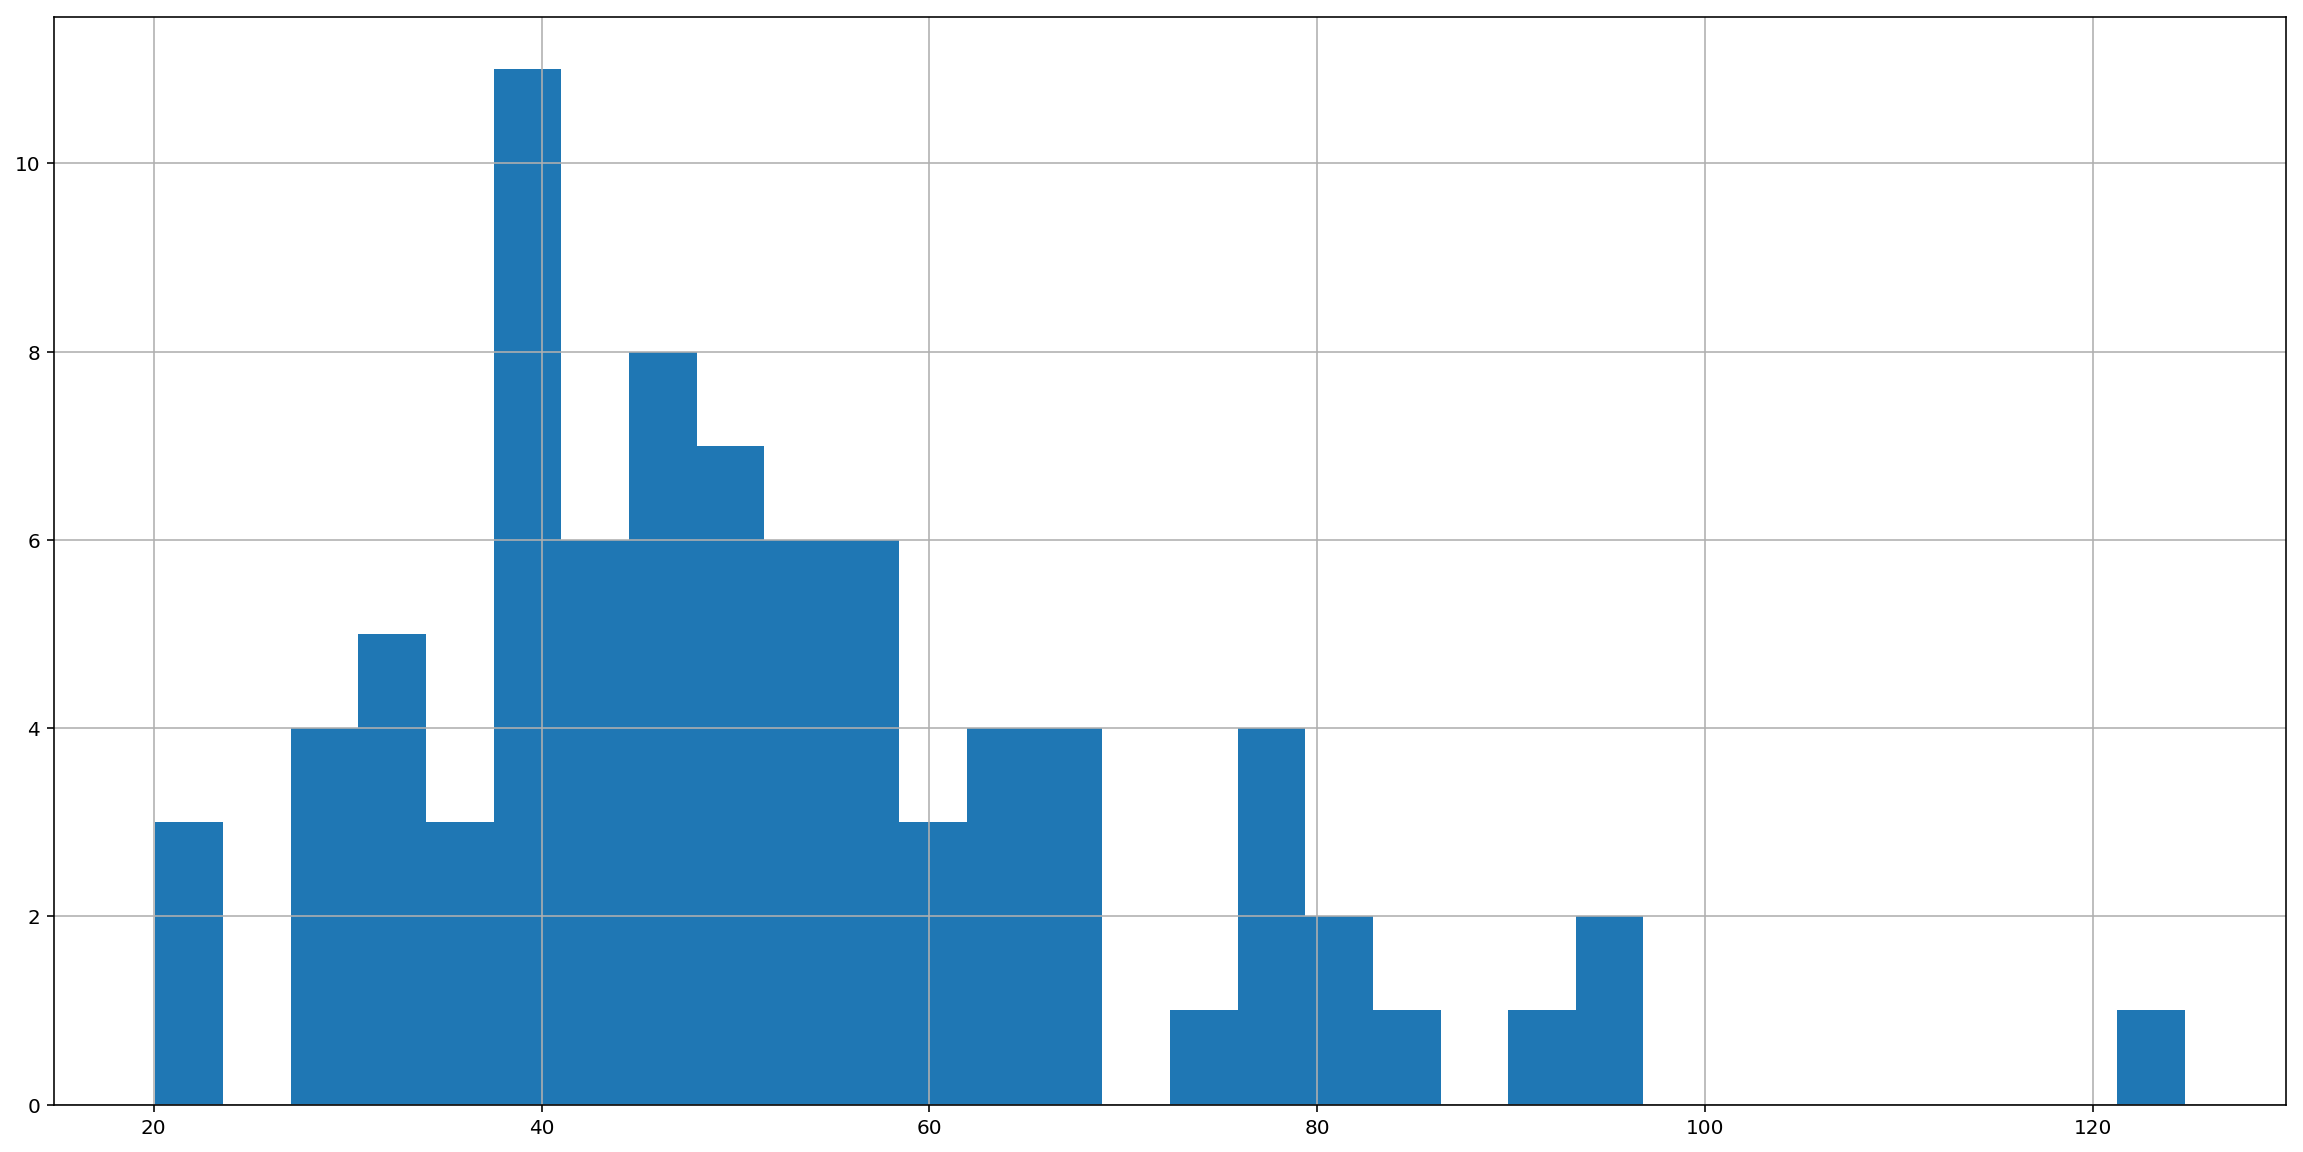

In [42]:
wettest_day_each_year.hist(bins=30)

### Example: extreme weather probabilities

We can also use the bootstrap to estimate confidence about probabilities of
events. Consider this question: **What is the probability that next year has a
day with more 60 mm of rain?**

First, what is the frequency of this event in the data?

In [43]:
(rain > 60).mean()

0.0008264178230777177

So 0.083% of days in Mitcham have had such extreme rainfall since 1936.

### Exercise: find how many years have had a day wetter than 60 mm

**Hint:** Use the `wettest_day_each_year` data

In [44]:
# %load solutions/how_many_years_wetter_than_60mm.ipy
(wettest_day_each_year > 60).sum()

22

### Exercise: uncertainty

The above was our empirical estimate.

In this exercise, we determine what uncertainty would we associate with that
estimate.

In [45]:
# First define a function that calculates the quantity
# of interest on the resampled data:

import numpy as np

def more_than_60_mm(rainfall):
    return (rainfall > 60).mean()

Now apply the ci() function to estimate the probability that next year has a day
with more 60 mm of rain.

In [46]:
# %load solutions/wettest_day_uncertainty.ipy